In [2]:
import os

import numpy as np
import pandas as pd

from shapely.geometry import LineString
from shapely.geometry import Point, MultiPoint, MultiLineString
from shapely.ops import linemerge, nearest_points

import geopandas as gpd
from geopandas import GeoDataFrame
from centerline.geometry import Centerline

from tqdm import tqdm 
from pandarallel import pandarallel
pandarallel.initialize(progress_bar=True, nb_workers=14)



INFO: Pandarallel will run on 14 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


## Get Sidewalk Centerlines

In [3]:
df = gpd.read_file("../data/Sidewalk.geojson")

In [4]:
#df = df.sample(1000)

In [5]:
df = df.to_crs('EPSG:3627')

In [6]:
df_dissolved = gpd.GeoDataFrame(geometry=gpd.GeoSeries([geom for geom in df.unary_union.geoms]))

In [7]:
df_dissolved

,geometry
0,"POLYGON ((279288.862 36801.977, 279286.702 368..."
1,"POLYGON ((279659.223 37016.441, 279659.301 370..."
2,"POLYGON ((279244.873 36936.874, 279243.940 369..."
3,"POLYGON ((279763.725 36970.047, 279762.763 369..."
4,"POLYGON ((279754.373 36968.171, 279751.748 369..."
...,...
43671,"POLYGON ((323451.861 66461.906, 323451.698 664..."
43672,"POLYGON ((323352.675 66523.841, 323357.236 665..."
43673,"POLYGON ((323371.910 66525.239, 323367.179 665..."
43674,"POLYGON ((323253.227 66542.982, 323253.211 665..."


In [8]:

df_exploded = df_dissolved.explode()

/tmp/ipykernel_2904984/78735745.py:1: FutureWarning: Currently, index_parts defaults to True, but in the future, it will default to False to be consistent with Pandas. Use `index_parts=True` to keep the current behavior and True/False to silence the warning.
  df_exploded = df_dissolved.explode()


<Axes: >

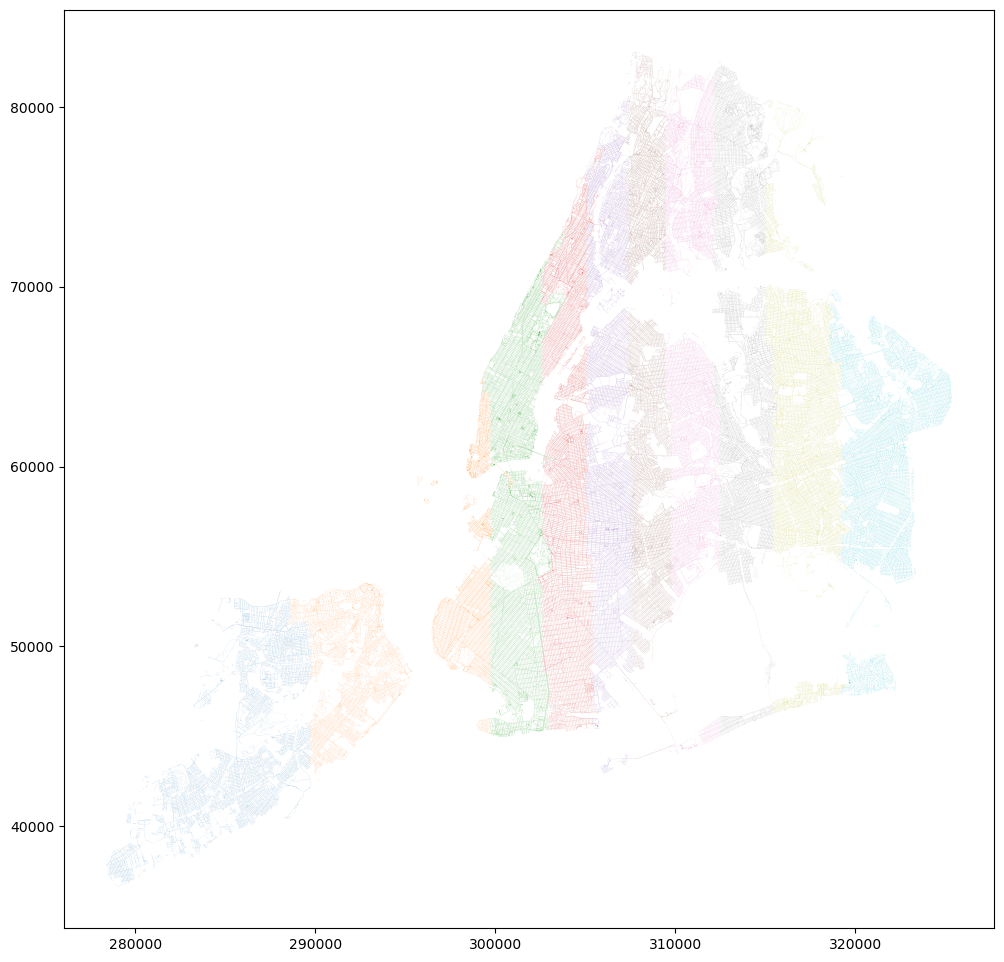

In [9]:
df_exploded.plot(figsize=(12, 12), cmap='tab10')

In [10]:
df_exploded

,,geometry
0,0,"POLYGON ((279288.862 36801.977, 279286.702 368..."
1,0,"POLYGON ((279659.223 37016.441, 279659.301 370..."
2,0,"POLYGON ((279244.873 36936.874, 279243.940 369..."
3,0,"POLYGON ((279763.725 36970.047, 279762.763 369..."
4,0,"POLYGON ((279754.373 36968.171, 279751.748 369..."
...,...,...
43671,0,"POLYGON ((323451.861 66461.906, 323451.698 664..."
43672,0,"POLYGON ((323352.675 66523.841, 323357.236 665..."
43673,0,"POLYGON ((323371.910 66525.239, 323367.179 665..."
43674,0,"POLYGON ((323253.227 66542.982, 323253.211 665..."


In [11]:
# parallelized version 
def get_centerline(row):
    try: 
        return Centerline(row['geometry'])
    except Exception as e:
        print(e)
        return None


df_exploded['centerlines'] = df_exploded.parallel_apply(lambda row: get_centerline(row), axis=1)

QH6347 qhull precision error (qh_mergefacet): wide merge for facet f29171 into f28631 for mergetype 1 (coplanar).  maxdist 3.6e-10 (19.1x) mindist -1.7e-09 (89.8x) vertexdist 0.94  Allow with 'Q12' (allow-wide)
ERRONEOUS FACET:
- f29171
    - flags: top upperDelaunay newfacet tested keepcentrum newmerge
    - merges: 35
    - normal:   -0.8427   0.5384 2.386e-12
    - offset:  -201.1403
    - center: 841.6939064441293 1690.868618573477 1521.638841783043 
    - maxoutside: 2.878434e-12
    - vertices: p7506(v5229) p7611(v5174) p7603(v5168) p7598(v5159) p7593(v5158) p7584(v5147) p7608(v3984) p7594(v3974) p7591(v3966) p7580(v3959) p7633(v3952) p7624(v3947) p7616(v2886) p7620(v2884) p7606(v2882) p7597(v2876) p7590(v2862) p7630(v2837) p7654(v2830) p7650(v2829) p7617(v2022) p7610(v2020) p7641(v1984) p7625(v1983) p7628(v1982) p7648(v1981) p7651(v1971) p7589(v1327) p7646(v1315) p7649(v1310) p7592(v883) p7637(v877) p7623(v876) p7645(v874) p7632(v540) p7602(v317) p7647(v313) p7622(v125)
    - ne

<Axes: >

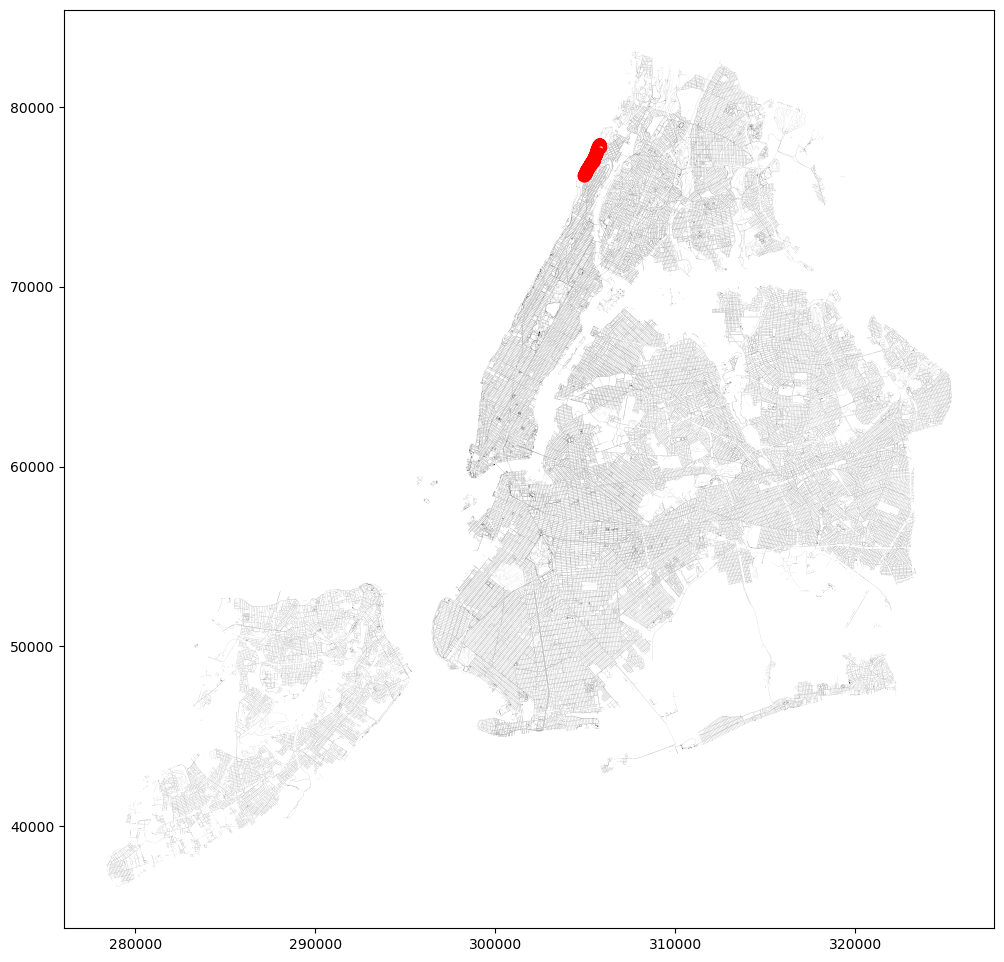

In [12]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(12, 12))

df_exploded.plot(ax=ax, color='black', alpha=1)
df_exploded[df_exploded['centerlines'].isna()].plot(ax=ax, color='red', alpha=1, edgecolor='red', linewidth=10)


In [13]:
# drop the rows with na centerline 
df_exploded = df_exploded.dropna(subset=['centerlines'])

In [14]:
df_exploded['cl_geom'] = df_exploded['centerlines'].apply(lambda x: x.geometry.geoms)

/share/ju/conda_virtualenvs/urbanekg/lib/python3.11/site-packages/geopandas/geodataframe.py:1528: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


In [15]:
df_exploded['cl_geom'].head()

0  0    (LINESTRING (279461.1185759885 36839.370568185...
1  0    (LINESTRING (279533.19698989706 36917.66604728...
2  0    (LINESTRING (279272.5431201088 36931.524967267...
3  0    (LINESTRING (279763.1427223235 36978.415692353...
4  0    (LINESTRING (279753.5512597656 36968.711912313...
Name: cl_geom, dtype: object

## Remove Short Line Ends

In [16]:
df_exploded['cl_geom'] = df_exploded['cl_geom'].parallel_apply(linemerge)

/share/ju/conda_virtualenvs/urbanekg/lib/python3.11/site-packages/geopandas/geodataframe.py:1528: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


In [17]:
df_exploded['cl_geom']

0      0    MULTILINESTRING ((278894.938642706 36824.71710...
1      0    MULTILINESTRING ((279546.6526100084 36865.0001...
2      0    MULTILINESTRING ((279231.6212813848 36925.0947...
3      0    MULTILINESTRING ((279761.6543722956 36984.3804...
4      0    MULTILINESTRING ((279686.6208212649 36951.2732...
                                  ...                        
43671  0    MULTILINESTRING ((323446.412238529 66465.53237...
43672  0    MULTILINESTRING ((323297.27891172934 66565.734...
43673  0    MULTILINESTRING ((323307.00180607964 66581.162...
43674  0    MULTILINESTRING ((323252.927561892 66546.34522...
43675  0    MULTILINESTRING ((323213.3082725311 66611.1550...
Name: cl_geom, Length: 43675, dtype: object

In [18]:
def remove_short_lines(line):
    
    if line.geom_type == 'MultiLineString':
        
        passing_lines = []
        line = line.geoms
    
        for i, linestring in enumerate(line):
            
            other_lines = MultiLineString([x for j, x in enumerate(line) if j != i])
            
            p0 = Point(linestring.coords[0])
            p1 = Point(linestring.coords[-1])
            
            is_deadend = False
            
            if p0.disjoint(other_lines): is_deadend = True
            if p1.disjoint(other_lines): is_deadend = True
            
            if not is_deadend or linestring.length > 5:                
                passing_lines.append(linestring)
            
        return MultiLineString(passing_lines)
            
    if line.geom_type == 'LineString':
        return line

In [19]:
df_exploded['cl_geom'] = df_exploded['cl_geom'].parallel_apply(remove_short_lines)

/share/ju/conda_virtualenvs/urbanekg/lib/python3.11/site-packages/geopandas/geodataframe.py:1528: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


In [20]:
df_exploded['cl_geom']

0      0    MULTILINESTRING ((278896.7966323264 36823.7942...
1      0    MULTILINESTRING ((279547.2563153305 36866.1904...
2      0    MULTILINESTRING ((279234.46960270026 36927.774...
3      0    MULTILINESTRING ((279764.7960677799 36971.8556...
4      0    MULTILINESTRING ((279752.7141586518 36969.3053...
                                  ...                        
43671  0    MULTILINESTRING ((323495.9441547861 66465.7585...
43672  0    MULTILINESTRING ((323297.2870548596 66565.7247...
43673  0    MULTILINESTRING ((323307.00180607964 66581.162...
43674  0    MULTILINESTRING ((323256.633535443 66550.40598...
43675  0    MULTILINESTRING ((323213.3082725311 66611.1550...
Name: cl_geom, Length: 43675, dtype: object

## Get Sidewalk Widths

In [21]:
df_exploded['cl_geom'] = df_exploded['cl_geom'].parallel_apply(lambda row: row.simplify(1, preserve_topology=True))

/share/ju/conda_virtualenvs/urbanekg/lib/python3.11/site-packages/geopandas/geodataframe.py:1528: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


In [22]:
def linestring_to_segments(linestring):
    return [LineString([linestring.coords[i], linestring.coords[i+1]]) for i in range(len(linestring.coords) - 1)]

In [23]:
def get_segments(line):
    
    line_segments = []

    if line.geom_type == 'MultiLineString':
        
        for linestring in line.geoms:
            
            line_segments.extend(linestring_to_segments(linestring))

    if line.geom_type == 'LineString':
        
        line_segments.extend(linestring_to_segments(line))

    return line_segments

In [24]:
df_exploded['segments'] = df_exploded['cl_geom'].parallel_apply(get_segments)

/share/ju/conda_virtualenvs/urbanekg/lib/python3.11/site-packages/geopandas/geodataframe.py:1528: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


In [25]:
df_exploded['centerlines'] = df_exploded['cl_geom']

In [26]:
def interpolate_by_distance(linestring):
    
    distance = 1
    all_points = []
    count = round(linestring.length / distance) + 1
    
    if count == 1:
        all_points.append(linestring.interpolate(linestring.length / 2))
    
    else:
        for i in range(count):
            all_points.append(linestring.interpolate(distance * i))
    
    return all_points

def interpolate(line):
    
    if line.geom_type == 'MultiLineString':
        
        all_points = []
        
        for linestring in line:
            all_points.extend(interpolate_by_distance(linestring))
        
        return MultiPoint(all_points)
            
    if line.geom_type == 'LineString':
        return MultiPoint(interpolate_by_distance(line))
    
    
def polygon_to_multilinestring(polygon):

    return MultiLineString([polygon.exterior] + [line for line in polygon.interiors])
    

def get_avg_distances(row):
    
    avg_distances = []
    
    sidewalk_lines = polygon_to_multilinestring(row.geometry)
    
    for segment in row.segments:
        
        points = interpolate(segment)
        
        distances = []
        
        for point in points.geoms:
            p1, p2 = nearest_points(sidewalk_lines, point)
            distances.append(p1.distance(p2))
            
        avg_distances.append(sum(distances) / len(distances))
        
    return avg_distances

In [27]:
df_exploded['avg_distances'] = df_exploded.parallel_apply(lambda row: get_avg_distances(row), axis=1)

/share/ju/conda_virtualenvs/urbanekg/lib/python3.11/site-packages/geopandas/geodataframe.py:1528: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


In [30]:
data = {'geometry': [], 'width': []}

for i, row in df_exploded.iterrows():

    for segment in row.segments:
        data['geometry'].append(segment)
    
    for distance in row.avg_distances:
        data['width'].append(distance * 2)

    
        
df_segments = pd.DataFrame(data)
df_segments = GeoDataFrame(df_segments, crs='EPSG:3627', geometry='geometry')

In [31]:
df_segments

,geometry,width
0,"LINESTRING (278896.797 36823.794, 278911.249 3...",1.489281
1,"LINESTRING (278911.249 36779.100, 278925.289 3...",2.213488
2,"LINESTRING (278925.289 36748.327, 278938.989 3...",1.424579
3,"LINESTRING (278938.989 36728.938, 278960.864 3...",1.675216
4,"LINESTRING (278960.864 36707.199, 278981.570 3...",1.540334
...,...,...
464963,"LINESTRING (323213.308 66611.155, 323229.454 6...",3.653181
464964,"LINESTRING (323229.454 66597.636, 323244.948 6...",3.841142
464965,"LINESTRING (323244.948 66575.057, 323263.367 6...",4.534436
464966,"LINESTRING (323263.367 66561.982, 323265.883 6...",4.117645


In [35]:
df_segments = df_segments.to_crs('EPSG:2263')
df_segments['width'] = df_segments['width'] * 3.28084

In [37]:
df_segments.describe([0.01, 0.025, 0.05, 0.1, 0.25, 0.5, 0.75, 0.9, 0.95, 0.975, 0.99])

,width
count,464968.000000
mean,10.970257
std,7.321378
min,0.037179
1%,2.228138
2.5%,3.009277
5%,3.810014
10%,4.863993
25%,6.916793
50%,9.406464


In [36]:
df_segments.to_file("../data/sidewalkwidths_nyc.geojson", driver='GeoJSON')

In [50]:
# sanity check: load og file from sidewalkwidths nyc project, check width descriptive stats 
og = gpd.read_file("../data/sidewalkwidths_nyc_og.geojson")

In [53]:
og['width'].describe([0.01, 0.025, 0.05, 0.1, 0.25, 0.5, 0.75, 0.9, 0.95, 0.975, 0.99])

count    464956.000000
mean          3.343834
std           2.234572
min           0.091440
1%            0.670560
2.5%          0.914400
5%            1.158240
10%           1.493520
25%           2.103120
50%           2.865120
75%           3.992880
90%           5.486400
95%           6.797040
97.5%         8.351520
99%          11.704320
max          50.413920
Name: width, dtype: float64